# **<center>SDSC3006 Lab : Support Vector Machines</center>**

TA : Nathanael Tepakbong (Nath)  
Email : ntepakbo-c@my.cityu.edu.hk  
Source material : https://www.statlearning.com/

### Importing the necessary packages :

In [1]:
#if needed, uncomment and run this line to install ISLP
#!pip install ISLP==0.3.19

As always, we import the usual packages...

In [2]:
import numpy as np
from matplotlib.pyplot import subplots , cm
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table

As well as those necessary for this specific lab :

In [3]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator # shorthand notation

##I - Support Vector Classifier

We will now use the ``SVC()`` function from ``sklearn`` to fit a SVC to an arbitrary dataset. In particular, we will visually illustrate the influence of the parameter ``C``. Recall how $C$ was defined in the lecture notes as the "budget" we have for the data points to be outside of the margin $M$ :  

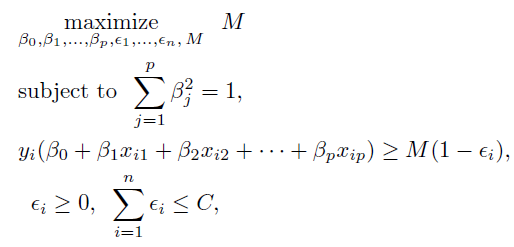

In ``sklearn`` however, the SVC problem is formulated in a different, but equivalent, manner (the equivalence is justified by a concept in optimization theory known as *duality*) :  

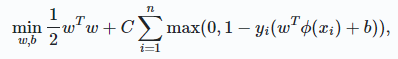

Where $\phi(x_i)\equiv x_i$.

**Task :** Read the documentation over at https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation and make sure you understand the two formulations of the SVC problem and why they are equivalent.

Roughly speaking, in the first formulation, $C$ corresponds to an "margin violation *budget*", while in the second formulation, $C$ should rather be seen as a "margin violation *cost*".  

The parameter ``C`` which will appear in our calls of the ``SVC`` function should be understood in the second way, implying that large values of ``C`` will lead to *small margins* while small values of ``C`` will lead to *wide margins* (why ?).

Now let's plot some 2D data to illustrate :

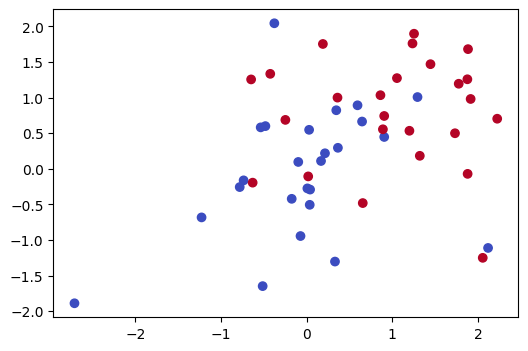

In [4]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1

fig , ax = subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm)

As we can see, the data is not linearly separable (why ?). Now let's fit a SVC to it :

In [5]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

And plot the resulting decision boundary :

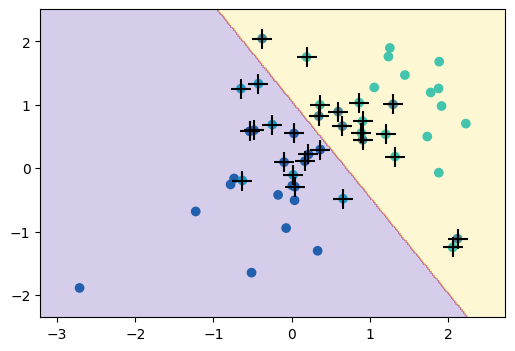

In [6]:
fig , ax = subplots(figsize=(6,4))
plot_svm(X, y, svm_linear, ax=ax)

In the above, the support vectors are marked as ``+`` while the others are marked as circles.  

Now let's see what happens if we decrease ``C`` :

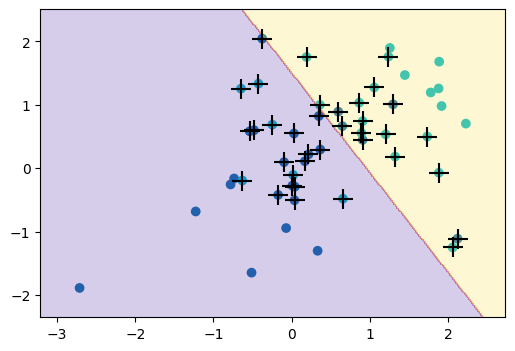

In [7]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
fig , ax = subplots(figsize=(6,4))
plot_svm(X, y, svm_linear_small, ax=ax)

As we can see, the number of support vectors has now increased, and the margin is wider. **Task :** explain whether/why these observations are consistent with the model's definition.

We can check the coefficients of the linear decision boundary as follows :

In [8]:
svm_linear.coef_

array([[1.17303943, 0.77348227]])

We can also perform $K$-fold cross-validation to find out the best value of $C$ :

In [9]:
kfold = skm.KFold(5, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_linear, {'C':[0.001,0.01,0.1,1,5,10,100]},
                        refit=True, cv=kfold, scoring='accuracy')
grid.fit(X, y)
grid.best_params_

{'C': 1}

And we can check the mean cross-validation error for each of the models in our grid through the ``grid.cv_results_`` object.

In [10]:
grid.cv_results_[('mean_test_score')]

array([0.46, 0.46, 0.72, 0.74, 0.74, 0.74, 0.74])

As we see, ``C=1`` is optimal although we get the same mean test score for all values of ``C in {1,5,10,100}``.

Let's now test how our SVC with the optimal value of ``C`` performs on test data :

In [11]:
X_test = rng.standard_normal((20, 2))
y_test = np.array ([ -1]*10+[1]*10)
X_test[y_test==1] += 1

We load the "optimal model" with the attribute ``best_estimator_`` :

In [12]:
best_ = grid.best_estimator_

y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


Hence for ``C=1``, $70\%$ of the test inputs are properly classified. Let's now see for a smaller value of ``C`` :

In [13]:
svm_ = SVC(C=0.001, kernel='linear').fit(X, y)

y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat , y_test)

Truth,-1,1
Predicted,,
-1,2,0
1,8,10


For ``C=0.001``, only $60\%$ of the inputs are properly classified. As expected, the performance is worse.

Let's now see what happens in the linearly separable case : We first tweak the dataset so the the observations are linearly separable

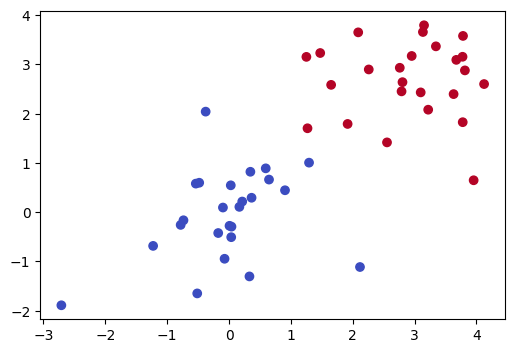

In [14]:
X[y==1] += 1.9

fig , ax = subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm)

In [15]:
svm_ = SVC(C=1e5, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat , y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


As expected, the fitted SVC can perfectly separate the two classes, even for very large ``C``, which essentially corresponds to hard margin classification. Let's check the decision boundary :

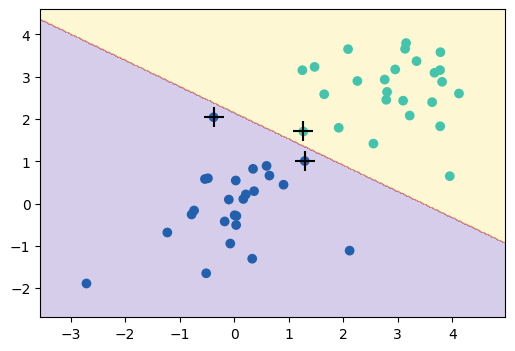

In [16]:
fig , ax = subplots(figsize=(6,4))
plot_svm(X, y, svm_, ax=ax)

We see that the margin is quite narrow and defined by three support vectors only ! This will most likely lead to overfitting. Let's instead check what happens for smaller values of ``C``.

In [17]:
svm_ = SVC(C=0.1, kernel='linear').fit(X, y)

y_hat = svm_.predict(X)
confusion_table(y_hat , y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


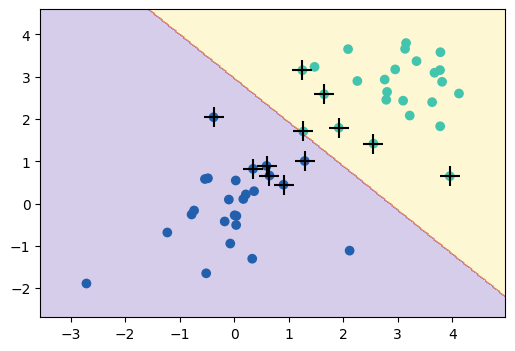

In [18]:
fig , ax = subplots(figsize=(6,4))
plot_svm(X, y, svm_, ax=ax)

As expected, the margin is now wider and defined by a larger number of support vectors. One would expect this model to generalize better than the one with ``C=1e5``.  

**Task :** Discuss how the two decision boundaries obtained for ``C=1e5`` and ``C=1`` relate to the bias-variance trade-off.  

**Task :** Test the obtained models for ``C=1e5`` and ``C=1`` on a test dataset of size ``1000``. Did you get the results you expect ?

##II - Support Vector Machine

We will now illustrate how to implement Support Vector Machine Classification using the libraries we've been using. Essentially, the implementation remains the same, except that we now specify the ``kernel`` argument of ``SVC()`` to be something other than ``linear``.

We first create a dataset with non-linear class boundary :

In [19]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

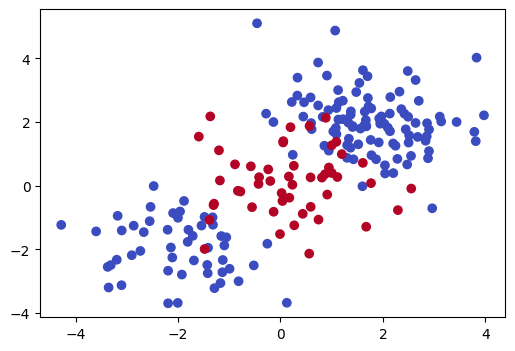

In [20]:
fig , ax = subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm)

This dataset is clearly not linearly separable. We randomly split it into a training and testing group and fit a SVM to it with ``rbf`` kernel and ``gamma=1`` :

In [21]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y,
                                                          test_size=0.5,
                                                          random_state=0)

svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train , y_train)

SVC(C=1, gamma=1)

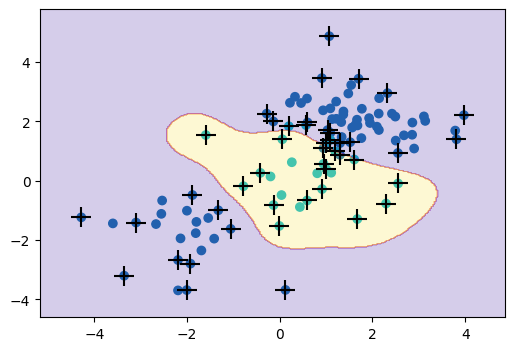

In [22]:
fig , ax = subplots(figsize=(6,4))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

As we see in the plot, there are quite many misclassified examples. We can "fix" this by increasing the value of ``C``, which will penalize misclassifications more harshly :

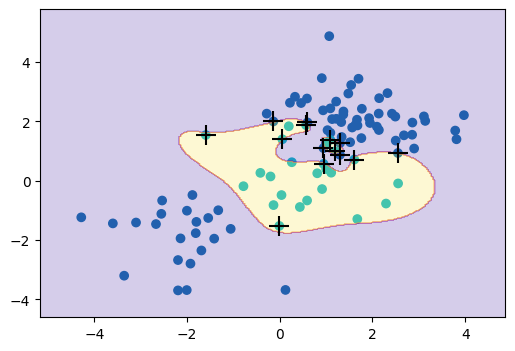

In [23]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train , y_train)

fig , ax = subplots(figsize=(6,4))
plot_svm(X_train, y_train, svm_rbf, ax=ax)

So we have now drastically decreased the amount of misclassified examples. However, the price to pay for this "improvement" is that the decision boundary is now highly irregular and likely overfits the training data. (**Task :** discuss how the two decision boundaries above illustrate the bias-variance tradeoff for SVMs)

As often when faced with such situations, we can perform cross-validation to identify which hyperparameter value ``C`` is optimal :

In [24]:
kfold = skm.KFold(5, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_rbf, {'C':[0.1,1,10,100,1000],
                        'gamma':[0.5,1,2,3,4]},
                         refit=True,
                         cv=kfold,
                         scoring='accuracy')

grid.fit(X_train , y_train)
grid.best_params_

{'C': 1, 'gamma': 0.5}

We can now check how our best SVM performs on the testing data :

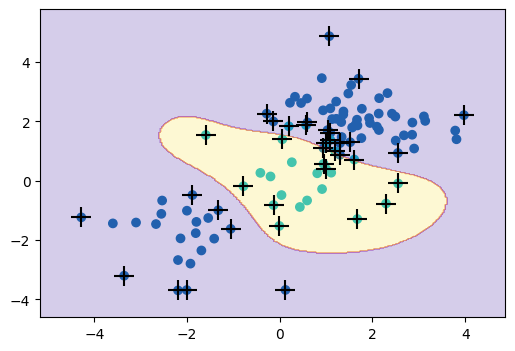

In [25]:
best_svm = grid.best_estimator_

fig , ax = subplots(figsize=(6,4))
plot_svm(X_train, y_train, best_svm, ax=ax)

In [26]:
y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test , y_test)

Truth,1,2
Predicted,,
1,69,6
2,6,19


##III - ROC Curves
Because the output of our SVM for some input $x_i$ is given by the real number $y_i(w^T\phi(x_i) + b)$, which we compare to the threshold $1$, we can compute plot the *receiver operating characteristic curve*, also known as *ROC curve*, to assess the performance of the SVM classifier. Loosely speaking, we will consider that the performance of our classifier is good if the area under the ROC curve (known as *area under ROC curve* or *AUC* is close to), meanwhile the performance will be considered poor if the AUC is close to (or less than) 0.5.  

For an introdcution to ROC and AUC, one may consult the following resources :

*   https://www.youtube.com/watch?v=4jRBRDbJemM
*   https://en.wikipedia.org/wiki/Receiver_operating_characteristic
*   https://stats.stackexchange.com/questions/105501/understanding-roc-curve





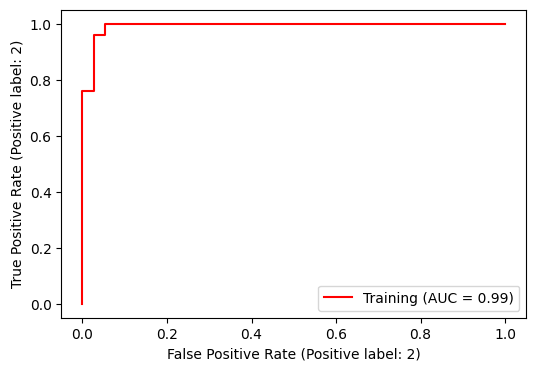

In [27]:
fig, ax = subplots(figsize=(6,4))
roc_curve(best_svm, X_train, y_train, name='Training', color='r', ax=ax)

Here the accuracy of the SVM seems excellent. By taking a large value of ``gamma`` we can have more flexibility and thus further increase the AUC :

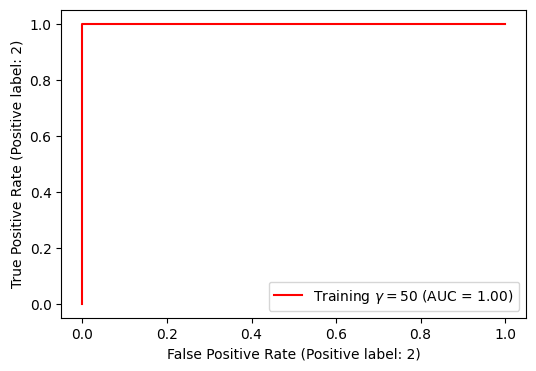

In [28]:
svm_flex = SVC(kernel="rbf", gamma=50, C=1)
svm_flex.fit(X_train , y_train)

fig , ax = subplots(figsize=(6,4))
roc_curve(svm_flex, X_train, y_train, name='Training $\gamma=50$', color='r',
          ax=ax)

We now have perfect accuracy ! **Task :** explain why the accuracy improved so much after increasing the value of ``gamma`` (you might want to plot the decision boundary of ``svm_flex``)

Beware : both of the obtained ROC curves are for *training data* only, we need to check them on testing data in order to have a sense of our model's expected accuracy.

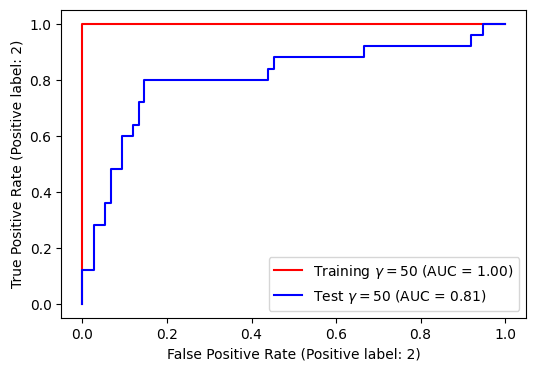

In [29]:
roc_curve(svm_flex, X_test , y_test, name='Test $\gamma=50$',
          color='b', ax=ax)
fig

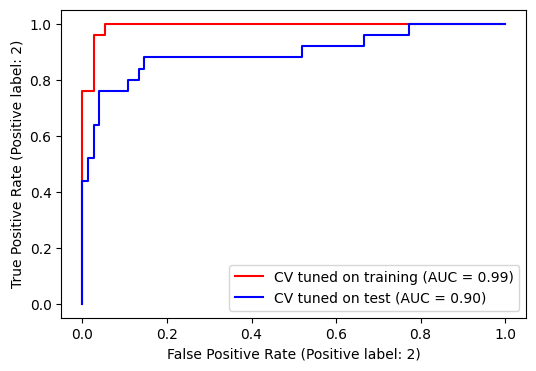

In [30]:
fig, ax = subplots(figsize=(6,4))

for (X_, y_, c, name) in zip( (X_train , X_test), (y_train , y_test), ('r', 'b'),
                            ('CV tuned on training', 'CV tuned on test')):
    roc_curve(best_svm , X_, y_, name=name, ax=ax, color=c)

**Task :** comment the obtained results and how they illustrate, again, the bias-variance tradeoff

##IV - SVM with Multiple Classes  

In case where there are not just two, but $K>2$ classes to choose from, we can still use SVM to perform *multi-class classification* by using either the *one-versus-one* approach or the *one-versus-all* approach, which consist in :

*   One-versus-all : train $K$ binary SVMs, where each has one class as ``+1`` and all the other classes as ``-1``. Then for a new input, the classification is given by the classifier for which it got the highest score
*   One-versus-one : Train $K(K-1)/2\ $ SVMS, where each has one class as ``+1``, and another class as ``-1``. For a new input, we apply all the classifiers to it and the class which got the highest number of ``+1`` gets predicted.



We now demonstrate a simple implementation of this scheme : we add an additional class to our original dataset and fit it with an SVM using the one-versus-one approach.

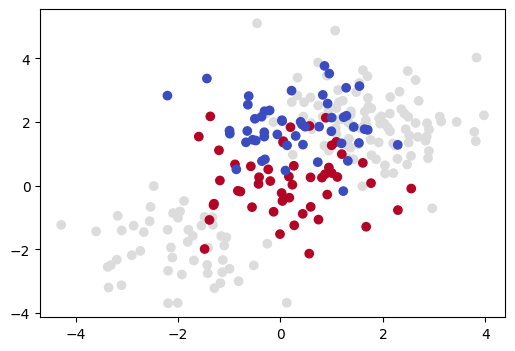

In [31]:
rng = np.random.default_rng (123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0]*50])
X[y==0,1] += 2

fig , ax = subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm)

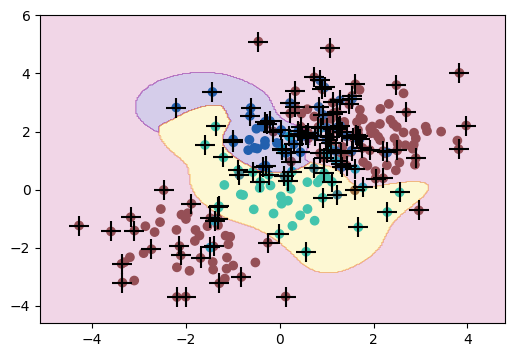

In [32]:
svm_rbf_3 = SVC(kernel="rbf", C=10, gamma=1, decision_function_shape='ovo')
svm_rbf_3.fit(X, y)

fig , ax = subplots(figsize=(6,4))
plot_svm(X, y, svm_rbf_3, scatter_cmap=cm.tab10, ax=ax)

## V - Application to Gene Expression Data

Laslty, we briefly show how to use this model on the ``Khan`` dataset.

In [33]:
Khan = load_data('Khan')
Khan['xtrain'].shape , Khan['xtest'].shape

((63, 2308), (20, 2308))

We see that the dataset consists of elements with 2308 features, while the total amount of available datapoints is only 83. Therefore we will go for a linear kernel, as it should be easy to find a 2308-dimensional hyperplane which separates a set of at most 63 points.

In [34]:
khan_linear = SVC(kernel='linear', C=10)
khan_linear.fit(Khan['xtrain'], Khan['ytrain'])
confusion_table(khan_linear.predict(Khan['xtrain']),
Khan['ytrain'])

Truth,1,2,3,4
Predicted,,,,
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


As expected, the training data has been perfeclty separated. Now for the test data :

In [35]:
confusion_table(khan_linear.predict(Khan['xtest']), Khan['ytest'])

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


We see two misclassifications errors, but overall it seems like an acceptable performance.

**Task :** Train an SVM with ``rbf`` kernel on this dataset and use cross-validation to find the best possible parameter values. Does the performance improve ? Comment your results.